In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import pickle as pkl
import math
import glob
import os

from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sb
import matplotlib.colors as mcolors

import sys
sys.path.append('/'.join(os.getcwd().split('/')[:-2]+['eval','cleaned','']))
from params_opt_maps import *

In [2]:
path_data='/om2/user/khrovati/data/cross_system_integration/'
path_names=path_data+'names_parsed/'
path_fig=path_data+'figures/'

In [11]:
# Names
model_map=pkl.load(open(path_names+'models.pkl','rb'))
param_map=pkl.load(open(path_names+'params.pkl','rb'))
param_map_rev=dict(zip(param_map.values(),param_map.keys()))
metric_map=pkl.load(open(path_names+'metrics.pkl','rb'))
dataset_map=pkl.load(open(path_names+'datasets.pkl','rb'))
metric_meaning_map=pkl.load(open(path_names+'metric_meanings.pkl','rb'))
metric_map_rev=dict(zip(metric_map.values(),metric_map.keys()))
dataset_map_rev=dict(zip(dataset_map.values(),dataset_map.keys()))
system_map=pkl.load(open(path_names+'systems.pkl','rb'))
params_opt_map=pkl.load(open(path_names+'params_opt_model.pkl','rb'))
params_opt_gene_map=pkl.load(open(path_names+'params_opt_genes.pkl','rb'))
param_opt_vals=pkl.load(open(path_names+'optimized_parameter_values.pkl','rb'))

# cmap
model_cmap=pkl.load(open(path_names+'model_cmap.pkl','rb'))
dataset_cmap=pkl.load(open(path_names+'dataset_cmap.pkl','rb'))
obs_col_cmap=pkl.load(open(path_names+'obs_col_cmap.pkl','rb'))
metric_background_cmap=pkl.load(open(path_names+'metric_background_cmap.pkl','rb'))

In [4]:
# Load data and keep relevant runs
ress=[]
for dataset,dataset_name in dataset_map.items():
    print(dataset_name)
    path_integration=f'{path_data}eval/{dataset}/integration/'
    res=[]
    for run in glob.glob(path_integration+'*/'):
        if os.path.exists(run+'args.pkl') and \
            os.path.exists(run+'scib_metrics.pkl'):
            args=pd.Series(vars(pkl.load(open(run+'args.pkl','rb'))))
            metrics=pd.Series(pkl.load(open(run+'scib_metrics.pkl','rb')))
            data=pd.concat([args,metrics])
            name=run.split('/')[-2]
            data.name=name
            res.append(data)
    res=pd.concat(res,axis=1).T

    # Parse res table

    # Parse params
    res['params_opt']=res.params_opt.replace(params_opt_correct_map)
    res['param_opt_col']=res.params_opt.replace(param_opt_col_map)
    res['param_opt_val']=res.apply(
        lambda x: (x[x['param_opt_col']] if not isinstance(x[x['param_opt_col']],dict)
                  else x[x['param_opt_col']]['weight_end']) 
                  if x['param_opt_col'] is not None else 0,axis=1)
    # param opt val for plotting - converted to str categ below
    res['param_opt_val_str']=res.apply(
        lambda x: x[x['param_opt_col']] if x['param_opt_col'] is not None else np.nan,axis=1)
    
    res['params_opt']=pd.Categorical(res['params_opt'],sorted(res['params_opt'].unique()), True)

    # Keep relevant params and name model
    params_opt_vals=set(params_opt_map.keys())
    res_sub=res.query('params_opt in @params_opt_vals').copy()
    res_sub['model']=res_sub.params_opt.replace(params_opt_map).astype(str)   
    # Models present in data but have no params opt
    nonopt_models=list(
        (set(params_opt_map.values()) & set(res_sub['model'].unique()))-set(
        [model for models,params_vals in param_opt_vals for model in models]))
    # Query: model not opt OR model belongs to one of the models that have opt params
    # and if given param is opt then it is within list of param values
    res_query=[f'model in {nonopt_models}']
    # Models with opt params
    for models,params_vals in param_opt_vals:
        res_query_sub=[]
        # Param value in vals if param was optimised
        for param,vals in params_vals:
            # For param check if it was opt in data as else there will be no col for it
            if param in res_sub.columns:
                res_query_sub.append(f'({param} in {vals} & "{param}"==param_opt_col)')
        # Only add to query models for which any param was opt
        if len(res_query_sub)>0:
            res_query_sub='(('+' | '.join(res_query_sub)+f') & model in {models})'
            res_query.append(res_query_sub)
    res_query=' | '.join(res_query)
    #print(res_query)
    res_sub=res_sub.query(res_query).copy()

    # Add pretty model names
    res_sub['model_parsed']=pd.Categorical(
        values=res_sub['model'].map(model_map),
        categories=model_map.values(), ordered=True)
    # Add prety param names
    res_sub['param_parsed']=pd.Categorical(
        values=res_sub['param_opt_col'].map(param_map),
        categories=param_map.values(), ordered=True)
    # Add gene names
    res_sub['genes_parsed']=pd.Categorical(
        values=res_sub['params_opt'].map(params_opt_gene_map),
         categories=list(dict.fromkeys(params_opt_gene_map.values())), ordered=True)
    
    display(res_sub.groupby(['model_parsed','param_parsed','genes_parsed'],observed=True).size())
    
    # Store
    res_sub['dataset_parsed']=dataset_name
    ress.append(res_sub)
    
ress=pd.concat(ress)
ress['dataset_parsed']=pd.Categorical(
    values=ress['dataset_parsed'],
    categories=list(dataset_map.values()), ordered=True)

# plotting param vals
ress['param_opt_val_str']=pd.Categorical(
    values=ress['param_opt_val_str'].fillna('none').astype(str),
    categories=[str(i) for i in 
                sorted([i for i in ress['param_opt_val_str'].unique() if not np.isnan(i)])
               ]+['none'],
    ordered=True)

Mouse-Human


model_parsed  param_parsed     genes_parsed
VAMP          KL LW            OTO             12
CYC           Cycle LW         OTO             12
VAMP+CYC      Cycle LW         OTO             12
cVAE          KL LW            OTO             12
scVI          KL LW            OTO             12
GLUE          Graph LW         OTO             12
                               FO              12
              Alignment LW     OTO             12
                               FO              12
              Graph W          OTO             12
                               FO              12
SATURN        Protein sim. LW  OTO             12
                               FO              12
SATURN-CT     Protein sim. LW  OTO             12
                               FO              12
dtype: int64

Organoid-Tissue


model_parsed  param_parsed  genes_parsed
VAMP          KL LW         OTO             12
CYC           Cycle LW      OTO             12
VAMP+CYC      Cycle LW      OTO             12
cVAE          KL LW         OTO             12
scVI          KL LW         OTO             12
GLUE          Graph LW      OTO             12
              Alignment LW  OTO             12
              Graph W       OTO             12
dtype: int64

Cell-Nuclei


model_parsed  param_parsed  genes_parsed
VAMP          KL LW         OTO             12
CYC           Cycle LW      OTO             12
VAMP+CYC      Cycle LW      OTO             12
cVAE          KL LW         OTO             12
scVI          KL LW         OTO             12
GLUE          Graph LW      OTO             12
              Alignment LW  OTO             12
              Graph W       OTO             12
dtype: int64

In [12]:
# HP-metric correlations
corrs=[]
group_cols=['model_parsed','param_parsed','dataset_parsed']
for group,res_sub in ress.query('genes_parsed=="OTO"').groupby(
    group_cols,observed=True,sort=True ):
    for metric,metric_name in metric_map.items():
        corr=dict(zip(group_cols,group))
        negate=param_map_rev[corr['param_parsed']] in { 
            'lam_graph','rel_gene_weight','pe_sim_penalty'}
        corr['HP corr.']=((-1 if negate else 1)*res_sub['param_opt_val'].astype(float)).corr(
            res_sub[metric].astype(float), method='spearman')
        corr['metric'] = metric_name
        corr['Optimized']=corr['model_parsed']+'\n'+corr['param_parsed'] +\
            ('' if not negate else ' (inv.)')
        corrs.append(corr)
corrs=pd.DataFrame(corrs)
corrs.rename({'dataset_parsed':'Dataset'},axis=1,inplace=True)

/tmp/ipykernel_36398/3263741164.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.axes[-1][0].set_xticklabels(g.axes[-1][0].get_xticklabels(),rotation=90)


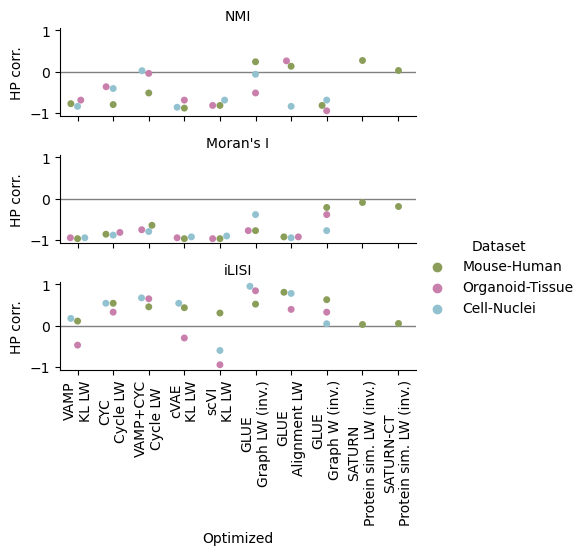

In [13]:
# Plot
palette={dataset_map[dataset]:color for dataset,color in dataset_cmap.items()}
g=sb.catplot(x='Optimized',y='HP corr.',hue='Dataset',row='metric', data=corrs, 
             height=1.5,aspect=3, kind='swarm',palette=palette)
# Make pretty
g.axes[-1][0].set_xticklabels(g.axes[-1][0].get_xticklabels(),rotation=90)
for ax in g.axes:
    ax[0].axhline(0,c='gray',lw=1)
    ax[0].set_title(ax[0].get_title().replace('metric = ',''),fontsize=10)
    
# Save
plt.savefig(path_fig+f'HP_metric_corr-corrs_all-swarm.pdf',
            dpi=300,bbox_inches='tight')
plt.savefig(path_fig+f'HP_metric_corr-corrs_all-swarm.png',
            dpi=300,bbox_inches='tight')